<a href="https://colab.research.google.com/github/nareekarn/All_project_in_class/blob/main/Covid_19_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download and Exploration Data

In [ ]:
!gdown --id 1NNkfq5MZ1KMeFrWhlm3Htt9OTGssL8U4


Downloading...
From: https://drive.google.com/uc?id=1NNkfq5MZ1KMeFrWhlm3Htt9OTGssL8U4
To: /content/owid-covid-data.csv
21.4MB [00:00, 131MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
data = pd.read_csv('/content/owid-covid-data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82837 entries, 0 to 82836
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               82837 non-null  object 
 1   continent                              78825 non-null  object 
 2   location                               82837 non-null  object 
 3   date                                   82837 non-null  object 
 4   total_cases                            80883 non-null  float64
 5   new_cases                              80881 non-null  float64
 6   new_cases_smoothed                     79880 non-null  float64
 7   total_deaths                           71308 non-null  float64
 8   new_deaths                             71466 non-null  float64
 9   new_deaths_smoothed                    79880 non-null  float64
 10  total_cases_per_million                80445 non-null  float64
 11  ne

In [ ]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


#Preparation and Visualization

In [ ]:
drop_col = 'tests_units'
data["date"]= pd.to_datetime(data["date"])
data = data.drop(drop_col,axis=1)
data.continent = data.continent.fillna('continent')

In [ ]:
country = ['World','Brunei','Cambodia','Timor','Indonesia','Laos','Malaysia','Myanmar','Philippines','Singapore','Thailand','Vietnam']

In [ ]:
def create_df(df, coun): #creat dataframe and fill na with values from interpolate function
  df_new = df[df.location==coun]
  df_new.set_index('date', inplace=True)
  df_new = df_new.interpolate(method='time')
  df_new = df_new.fillna(0)
  return df_new

In [ ]:
def num_of_people(df,name): #plot number of tatal_cases, total_vaccination, people_fully_vaccinated and total_deaths
  
  fig, ax = plt.subplots(figsize=(9, 5))

  ax.plot(df.total_cases, color='orange', label='total_cases')
  ax.plot(df.total_vaccinations, color='olive', label='total_vaccinations')
  ax.plot(df.people_fully_vaccinated, color='blue', label='people_fully_vaccinated')
  ax.plot(df.total_deaths, color='crimson', label='total_deaths')

  ax.set_xlabel('date')
  plt.title("Number of people in " + str(name))
  ax.grid(True)
  ax.legend(loc='upper left');

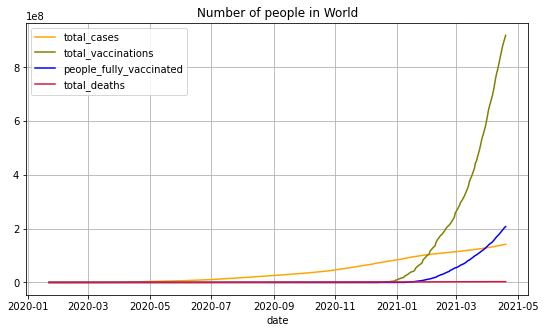

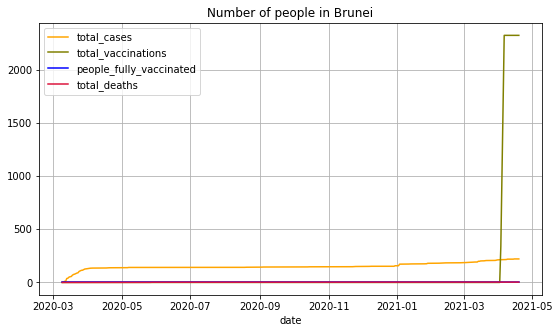

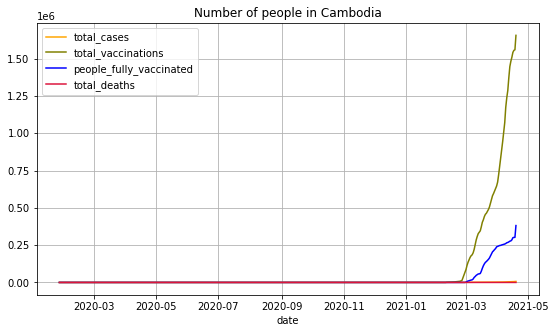

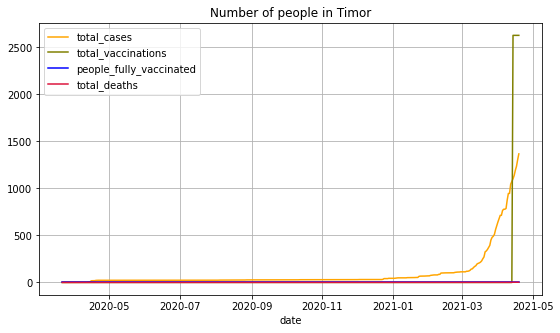

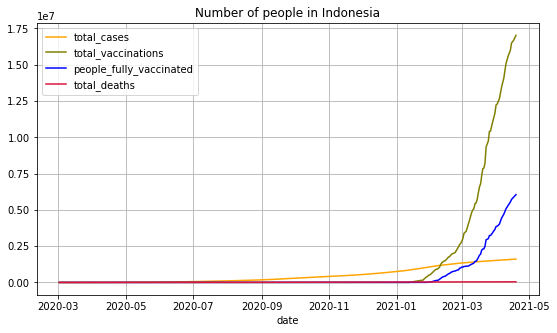

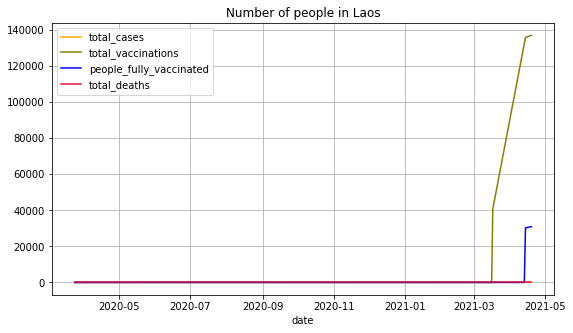

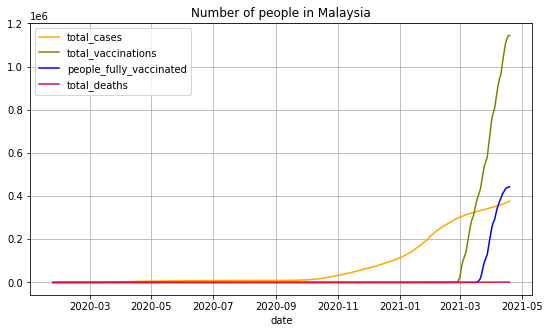

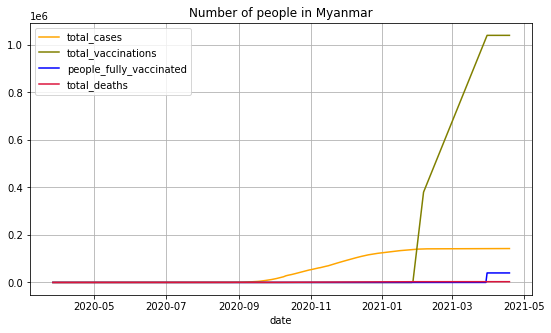

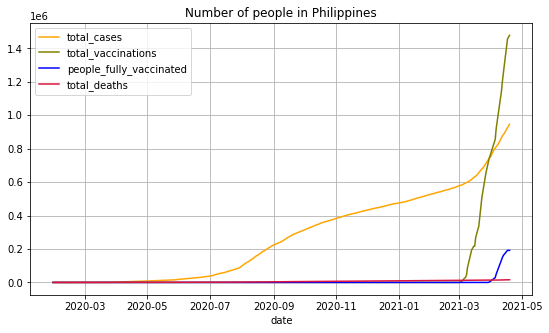

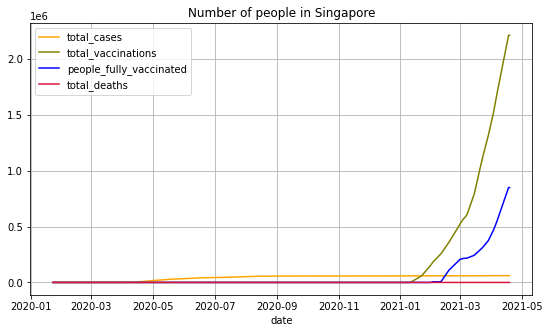

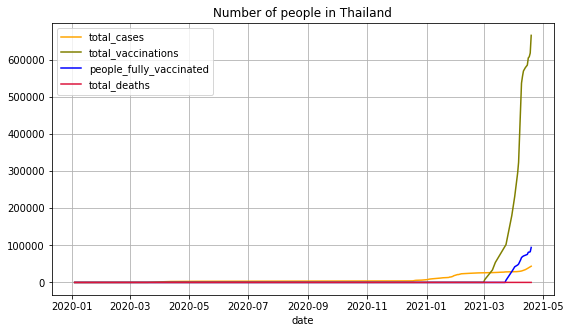

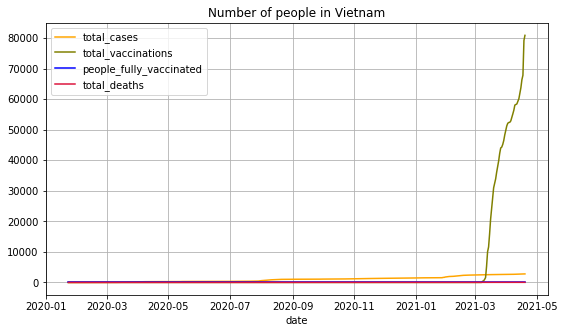

In [ ]:
for name in country:
  df_coun = create_df(data, name)
  num_of_people(df_coun,name)

In [ ]:
def correlation(df_corr):
  df_corr = df_corr.dropna(how='all', axis=1)
  for col in df_corr.columns:
    if len(df_corr[col].unique()) == 1:
        df_corr.drop(col,inplace=True,axis=1)
  lis = df_corr.corr()[['total_cases']]
  lis = lis[abs(lis) > 0.6].dropna()
  lis = list(lis.index.values)
  return df_corr[lis], lis

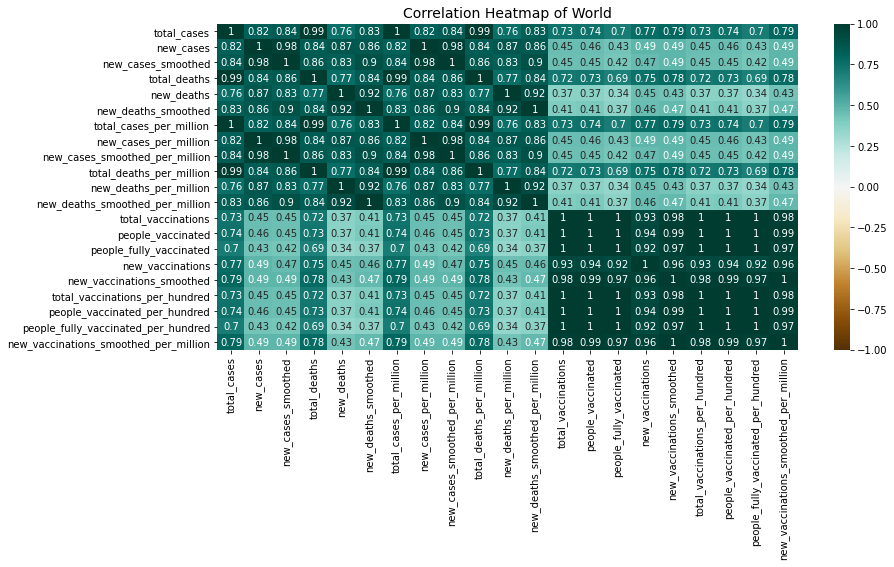

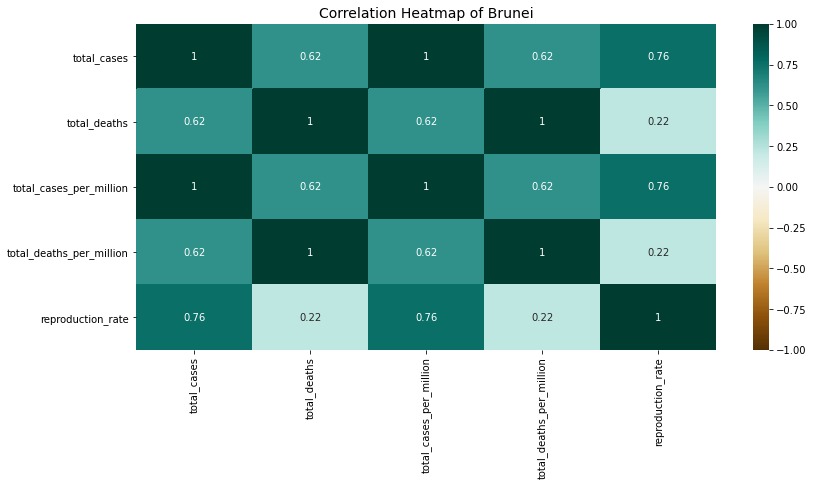

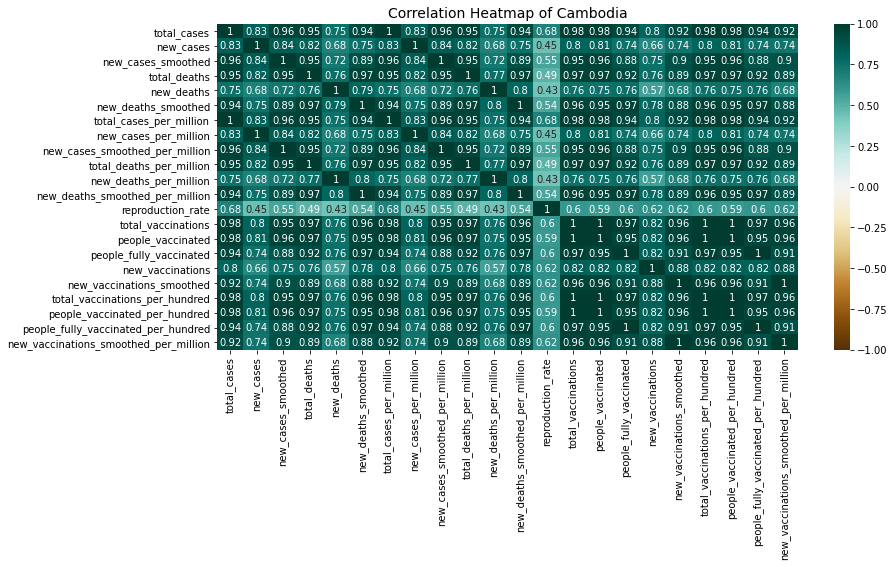

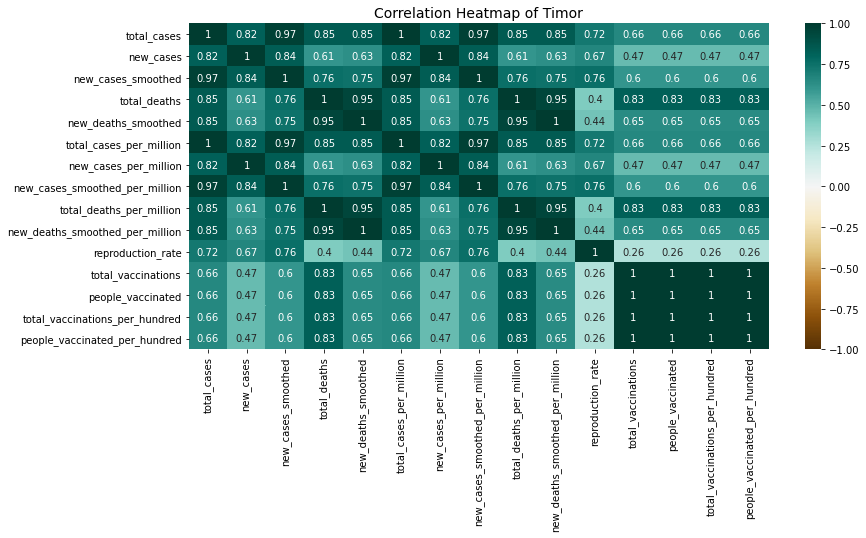

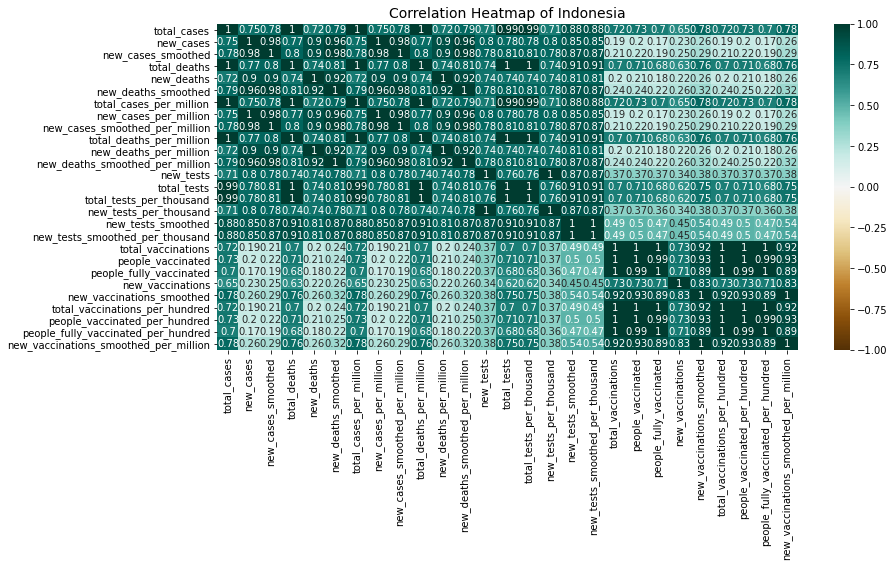

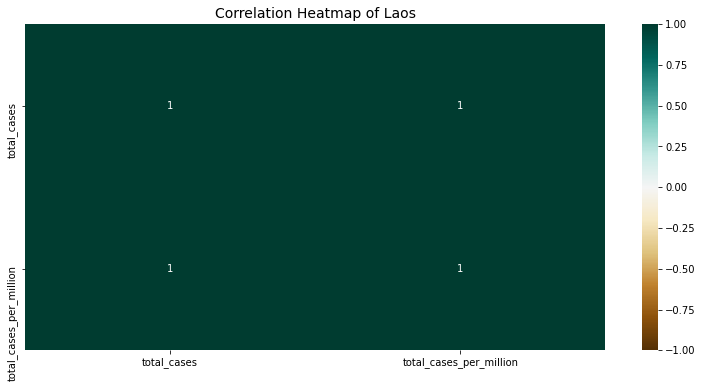

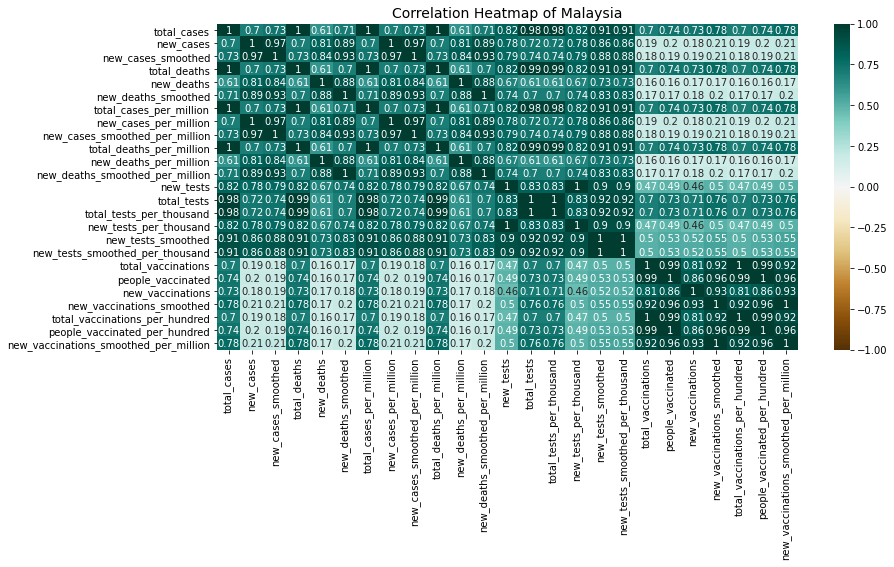

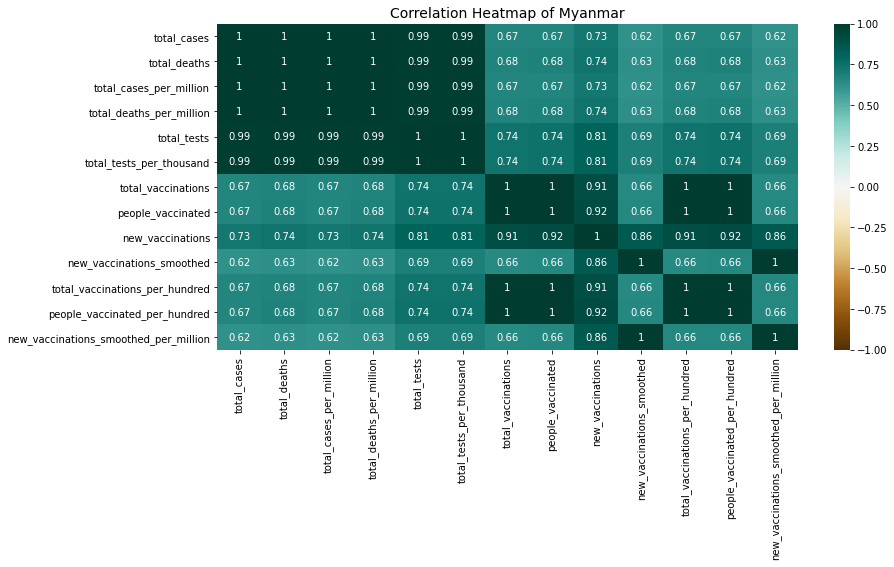

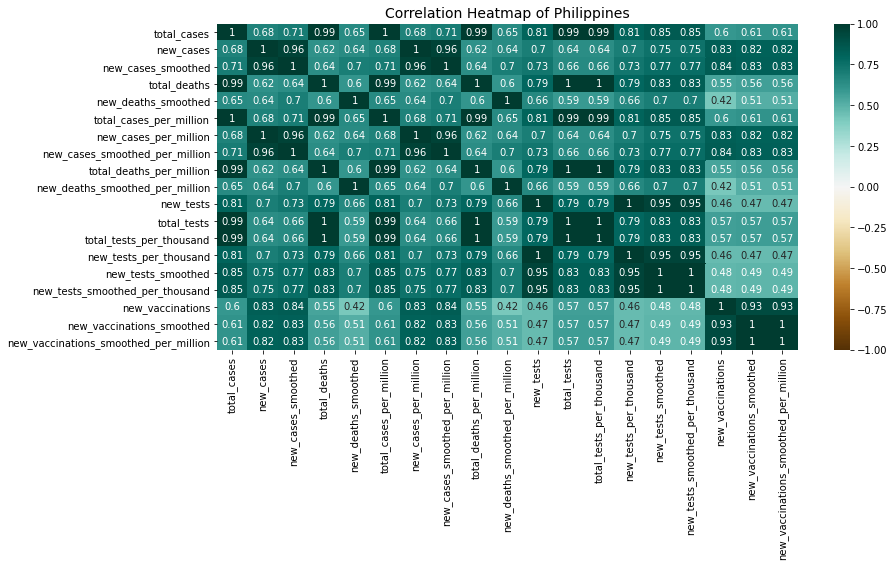

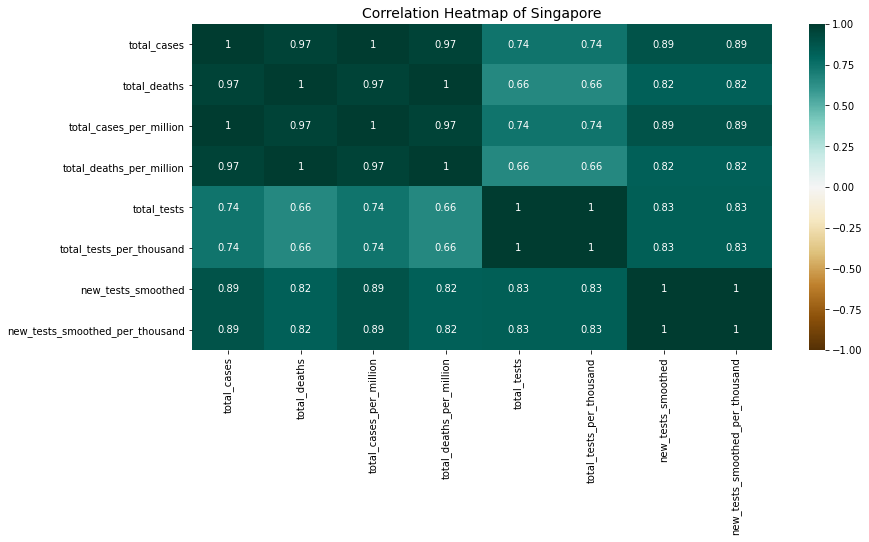

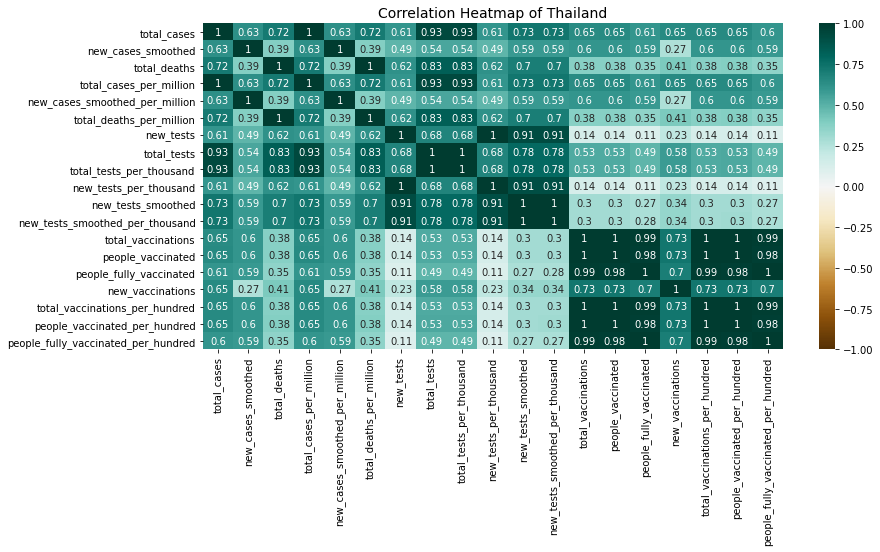

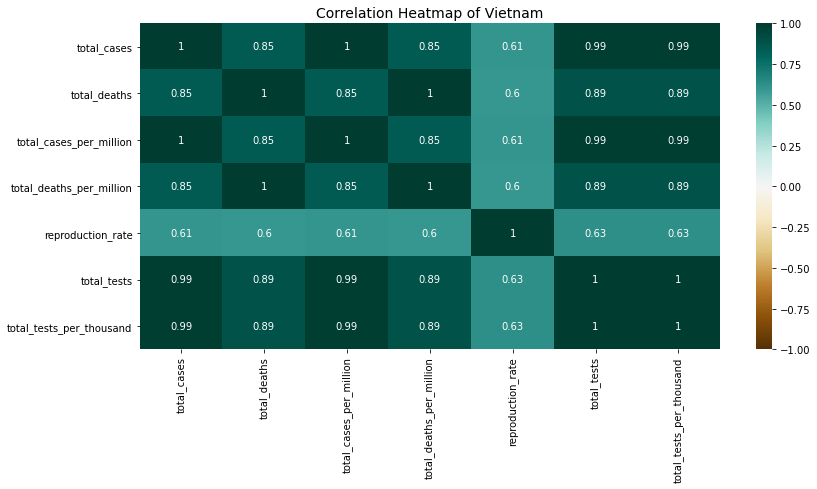

In [ ]:
for name in country:
  df_coun = create_df(data, name)
  dat, lis = correlation(df_coun)
  plt.figure(figsize=(13, 6))
  heatmap = sns.heatmap(dat[lis].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
  heatmap.set_title('Correlation Heatmap of '+ name, fontdict={'fontsize':14})

#Modeling

###Linear Regression

In [ ]:
def linear_next30days(df):  
  na = np.empty((30,1))
  na[:] = np.nan
  df['total_cases_next30days'] = np.concatenate((df['total_cases'].to_numpy()[30:], na), axis=None)

  X = df[:-30]
  X_train = X.drop(['total_cases_next30days'],axis=1)[7:-8]
  y_train = X['total_cases_next30days'][7:-8]
  X_test = X.drop(['total_cases_next30days'],axis=1)[-8:-1]
  y_test = X['total_cases_next30days'][-8:-1]
  
  model = LinearRegression()
  parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False],'n_jobs':[None,-1,2]}
  grid = GridSearchCV(model,parameters, cv=10,scoring = 'neg_mean_squared_error')
  grid.fit(X_train, y_train)

  reg = LinearRegression(grid.best_params_).fit(X_train, y_train)
  y_pred = reg.predict(X_test)

  return y_pred ,y_test

In [ ]:
def linear_next30days_may(df):
  na = np.empty((30,1))
  na[:] = np.nan
  df['total_cases_next30days_may'] = np.concatenate((df['total_cases'].to_numpy()[30:], na), axis=None)
  X_train = df.drop(['total_cases_next30days_may'],axis=1)[:'2021-03-20']
  y_train = df['total_cases_next30days_may'][:'2021-03-20']
  X_test = df.drop(['total_cases_next30days_may'],axis=1).loc['2021-04-10':'2021-04-16']

  model = LinearRegression()
  parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False],'n_jobs':[None,-1,2]}
  grid = GridSearchCV(model,parameters, cv=10)
  grid.fit(X_train, y_train)

  reg = LinearRegression(grid.best_params_).fit(X_train, y_train)
  y_pred = reg.predict(X_test)

  return y_pred

In [ ]:
real_TotalCases = []
TotalCases = []
PlaceAndTime = []
for con in country:
  dat = create_df(data, con)
  dat,lis = correlation(dat)
  y_pred, y_test = linear_next30days(dat)
  for pred in y_pred:
    TotalCases.append(pred)
  for real in y_test:
    real_TotalCases.append(real)
  for i in range(7):
    time = str(con)+'-2021-04-1'+ str(2 + i)
    PlaceAndTime.append(time)

#Evaluation

In [ ]:
mse = mean_squared_error(real_TotalCases, TotalCases)
print('MSE :', mse)

submit = {'PlaceAndTime': PlaceAndTime, 'TotalCases': TotalCases}         
submit = pd.DataFrame(submit)
submit.to_csv('submission.csv', index=False) 

MSE : 96530022630.30678


#Predict Total Cases in 10 May 2021 - 16 May 2021

In [ ]:
TotalCases = []
PlaceAndTime = []
for con in country:
  dat = create_df(data, con)
  dat,lis = correlation(dat)
  y_pred = linear_next30days_may(dat)
  for pred in y_pred:
    TotalCases.append(pred)
  for i in range(7):
    time = str(con)+'-2021-05-1'+ str(0 + i)
    PlaceAndTime.append(time)

submit = {'PlaceAndTime': PlaceAndTime, 'TotalCases': TotalCases}  
       
submit = pd.DataFrame(submit)
submit.to_csv('submission2.csv', index=False) 